In [1]:
import pandas as pd
import json
import pickle
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML

pd.set_option('display.max_colwidth', 500)

CSV_PATH = '../tpch_graphs_for_table_wo_2_17_20'
BENCHMARK = 'tpch'
SCALE_FACTOR = 10
# all except 2,17,20 because they dominate costs by orders of magnitude
QUERIES = [1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19,21,22]

In [2]:
class AlgorithmStep():
    def __init__(self, indexes, number_of_indexes, step, memory_consumption, workload_processing_cost):
        self.indexes = indexes
        self.number_of_indexes = number_of_indexes
        self.step = step
        self.memory_consumption = memory_consumption
        self.workload_processing_cost = workload_processing_cost
        
    def memory_consumption_gb(self):
        return f"{self.memory_consumption / 1E9:.2f}"
    
    def __repr__(self):
        return f"At step: {self.step} with {self.number_of_indexes} indexes ({self.memory_consumption_gb()} GB):\nCost: {self.workload_processing_cost}\nIndexes: {self.indexes}"
        
def calculate_cost(columns, row):
    cost = 0
    for column in columns:
        if column[0] == 'q':
            cost += float(json.loads(row[column])['Cost'])
    
    return cost

def shorten_tbl_name(index_name):
    # CAREFUL THIS COMPLETELY REMOVES nation
    if 'nation.' in index_name:
        return None
    index_name = index_name.replace('nation.', 'N.').replace('customer.', 'C.').replace('lineitem.', 'L.').replace('partsupp.', 'PS.').replace('orders.', 'O.').replace('supplier.', 'S.').replace('part.', 'P.')
    index_name = index_name.replace('l_', 'L_').replace('c_', 'C_').replace('ps_', 'PS_').replace('s_', 'S_').replace('p_', 'P_').replace('o_', 'O_')
    return index_name
    

def shorten_tbl_names_index_str(index_str):
    index_str = index_str.replace('nation.', 'N.').replace('customer.', 'C.').replace('lineitem.', 'L.').replace('partsupp.', 'PS.').replace('orders.', 'O.').replace('supplier.', 'S.').replace('part.', 'P.')
    index_str = index_str.replace('l_', 'L_').replace('c_', 'C_').replace('ps_', 'PS_').replace('s_', 'S_').replace('p_', 'P_').replace('o_', 'O_')
    return index_str

def cut_index_string(indexes):
    result = []
    removed_brackets = indexes[1:-1]
    indexes = removed_brackets.split('I(')
    for split_1 in indexes:
        without_brace = split_1.split(')')[0]
        if without_brace == '':
            continue
        index_name = f"I[{without_brace.replace('C ', '')}]"
        index_name = shorten_tbl_name(index_name)
        if index_name is None:
            continue
        result.append(index_name)
        
    return result

def get_new_and_removed_indexes_str(current_indexes, previous_indexes, workload=None):
    removed_indexes = previous_indexes - current_indexes
    new_indexes = current_indexes - previous_indexes            
    
    new_index_str = ', '.join(new_indexes) if len(new_indexes) else '-'
    removed_index_str = '\n'.join(removed_indexes) if len(removed_indexes) else '-'
    
    return new_index_str, removed_index_str

def get_cost(columns, row, previous_cost, initial_cost):
    cost = calculate_cost(columns, row)
    cost_relative_to_previous = cost / previous_cost * 100
    cost_relative_to_initial = cost / initial_cost * 100
    cost_string = f'{cost_relative_to_previous:.2f}% / {cost_relative_to_initial:.2f}%'
    
    return cost_string, cost, cost_relative_to_previous, cost_relative_to_initial

# def what_if_cost(workload, cost_evaluation, index_combination)
#     cost = cost_evaluation.calculate_cost(self.workload, index_combination,
#                                                    store_size=True)

def workload_to_str(workload):
    return str(workload.queries)

cache = {}

def what_if_cost(workload, index_combination):
    cache_key = (workload_to_str(workload), frozenset(index_combination))
    if cache_key not in cache:
        database_connector = PostgresDatabaseConnector('indexselection_tpch___10')
        cost_evaluation = CostEvaluation(database_connector)
        cost = cost_evaluation.calculate_cost(workload, index_combination)
        cache[cache_key]= cost
        database_connector.close()
    else:
        cost = cache[cache_key]
    return cost

def final_str(string):
    string = string[1:-1]
    string = string.replace(',C', ', C')
    string = string.replace('C ', '')
    string = string.replace('(', '[')
    string = string.replace(')', ']')
    if len(string) < 1:
        return '-'
    
    return string
    

In [3]:
df = pd.read_csv(f'{CSV_PATH}/results_no_index_{BENCHMARK}_{len(QUERIES)}_queries.csv', sep=';')
# df = df.drop(['q20'],axis=1)
initial_cost = calculate_cost(df.columns, df.iloc[0])
print(f'Initial cost: {initial_cost}')

Initial cost: 34763476.0


# Budget Table

In [4]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
parentdir = os.path.dirname(parentdir)
sys.path.insert(0,parentdir)

from selection.index import Index
from selection.workload import Workload
from selection.cost_evaluation import CostEvaluation
from selection.dbms.postgres_dbms import PostgresDatabaseConnector
from selection.what_if_index_creation import WhatIfIndexCreation


In [1]:
workload = pickle.load(open(f'{CSV_PATH}/workload.pickle', 'rb'))
# indexes_epic_pickled = pickle.load(open('../pickled_indexes/indexes_epic_tpch__queries.pickle', 'rb'))
# indexes_ibm_pickled = pickle.load(open('../pickled_indexes/indexes_ibm_tpch_21_queries.pickle', 'rb'))
# indexes_epic_history = pickle.load(open('../epic_index_combination_history.pickle', 'rb'))
indexes_ms_history = pickle.load(open(f'{CSV_PATH}/microsoft_index_combination_history.pickle', 'rb'))
indexes_drop_history = pickle.load(open(f'{CSV_PATH}/drop_index_drop_history.pickle', 'rb'))
indexes_epic_history = pickle.load(open(f'{CSV_PATH}/epic_index_combination_history.pickle', 'rb'))
indexes_ibm_history = pickle.load(open(f'{CSV_PATH}/ibm_index_combination_history.pickle', 'rb'))
indexes_drop_history = indexes_drop_history[::-1]
# indexes_ms_history = indexes_ms_history[::-1]
df_data_epic = pd.read_csv(f'{CSV_PATH}/results_epic_{BENCHMARK}_{len(QUERIES)}_queries.csv',sep=';')
df_data_ibm = pd.read_csv(f'{CSV_PATH}/results_ibm_{BENCHMARK}_{len(QUERIES)}_queries.csv',sep=';')

initial_cost = what_if_cost(workload, [])

new = []
for index in indexes_ms_history:
    if index.columns[0].table.name == 'nation' or index.columns[0].table.name == 'region':
        continue
    new.append(index)
indexes_ms_history = new

new = []
for index in indexes_drop_history:
    if index.columns[0].table.name == 'nation' or index.columns[0].table.name == 'region':
        continue
    new.append(index)
indexes_drop_history = new

algorithm_names = sorted(['Extend', 'DB2Advis', 'Drop', 'AutoAdmin'])
df_table = pd.DataFrame(columns=['Max Budget (GB)', 'Metric'] + algorithm_names)
metrics = ['% of initial cost', 'New Indexes']
last_steps_indexes_per_algo = {}
previous_cost = {}
for algorithm_name in algorithm_names:
    last_steps_indexes_per_algo[algorithm_name] = set()
    previous_cost[algorithm_name] = initial_cost
    

budgets_mb = [250, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4250, 5000, 5750, 6500, 8000, 10000, 12500, 15000, 17500, 20000, 22500, 25000]
indexes_epic = set()
indexes_drop = []
indexes_ibm = []
indexes_ms = []
budget_used_ibm = 0
budget_used_epic = 0
budget_used_drop = 0
budget_used_ms = 0
for budget_mb, (_, row_epic), (_, row_ibm)  in zip(budgets_mb, df_data_epic.iterrows(), df_data_ibm.iterrows()):
    budget_b = budget_mb * 1000 * 1000

    for idx, metric in enumerate(metrics):
        df_table = df_table.append(pd.DataFrame([[budget_mb / 1000 if idx == 0 else '', metric] + len(algorithm_names) * ['-']], columns=df_table.columns),ignore_index=True)
    
    # IBM memory budget
    current_indexes = set(cut_index_string(row_ibm['indexed columns']))    
    new_index_str, removed_index_str = get_new_and_removed_indexes_str(current_indexes, last_steps_indexes_per_algo['ibm'])
    df_table['ibm'].values[-1] = new_index_str
    last_steps_indexes_per_algo['ibm'] |= current_indexes
    
    cost_string, cost, _, cost_relative_to_initial = get_cost(df_data_ibm.columns, row_ibm, previous_cost['ibm'], initial_cost)
    previous_cost['ibm'] = cost
    df_table['ibm'].values[-2] = f"{cost_relative_to_initial:.2f}"
        
#     # IBM step
#     indexes_new_ibm = []
#     excluded_indexes = 0
#     for index in indexes_ibm_pickled:
#         if budget_used_ibm + index.estimated_size < budget_b:
#             cost_with_index = what_if_cost(workload, [index])
#             if (cost_with_index * 1.005 >= previous_cost['ibm']):
#                 excluded_indexes += 1
#                 continue
#             indexes_new_ibm.append(index)
#             budget_used_ibm += index.estimated_size
#         else:
#             break
        
#     indexes_ibm += indexes_new_ibm
#     indexes_ibm_pickled = indexes_ibm_pickled[len(indexes_new_ibm) + excluded_indexes:]
#     cost_ibm = what_if_cost(workload, indexes_ibm)
#     previous_cost['ibm'] = cost_ibm
    
#     df_table['ibm'].values[-1] = final_str(shorten_tbl_names_index_str(str(indexes_new_ibm)))
#     df_table['ibm'].values[-2] = f"{cost_ibm / initial_cost * 100:.2f}"
    
    # EPIC memory budget
    current_indexes = set(cut_index_string(row_epic['indexed columns']))    
    new_index_str, removed_index_str = get_new_and_removed_indexes_str(current_indexes, last_steps_indexes_per_algo['epic'])
    df_table['epic'].values[-1] = new_index_str
    last_steps_indexes_per_algo['epic'] |= current_indexes
    
    cost_string, cost, _, cost_relative_to_initial = get_cost(df_data_epic.columns, row_epic, previous_cost['epic'], initial_cost)
    previous_cost['epic'] = cost
    df_table['epic'].values[-2] = f"{cost_relative_to_initial:.2f}"
    
    # EPIC step
#     indexes_new_epic = set()
#     break_outer = False
#     steps_applicable = []
    
#     for step, history_step in enumerate(indexes_epic_history):
#         for index in history_step:
#             if index in indexes_epic:
#                 continue
#             budget_used_epic += index.estimated_size
#         if budget_used_epic > budget_b:
#             for index in history_step:
#                 budget_used_epic -= index.estimated_size
#             break
#         steps_applicable.append(history_step)
#     indexes_epic_history = indexes_epic_history[step:]
    
#     for history_step in steps_applicable:
#         for index in history_step:
#             if index in indexes_epic:
#                 continue
#             indexes_new_epic |= set([index])
#             if len(index.columns) > 1:
#                 indexes_epic_copy = indexes_epic.copy()
#                 for position, index_old in enumerate(indexes_epic_copy):
#                     if index.subsumes(index_old):
#                         budget_used_epic -= index_old.estimated_size
#                         indexes_epic.remove(index_old)
#     indexes_epic |= indexes_new_epic
#     cost_epic = what_if_cost(workload, indexes_epic)
#     previous_cost['epic'] = cost_epic

#     df_table['epic'].values[-2] = shorten_tbl_names_index_str(str(indexes_new_epic))
#     df_table['epic'].values[-1] = f"{cost_epic / initial_cost * 100:.2f}"
    
    
    # DROP
    indexes_new_drop = []
    for index in indexes_drop_history:
        if budget_used_drop + index.estimated_size < budget_b:
            indexes_new_drop.append(index)
            budget_used_drop += index.estimated_size
        else:
            break
    indexes_drop += indexes_new_drop
    indexes_drop_history = indexes_drop_history[len(indexes_new_drop):]
    cost_drop = what_if_cost(workload, indexes_drop)
    previous_cost['drop'] = cost_drop
    
    df_table['drop'].values[-1] = final_str(shorten_tbl_names_index_str(str(indexes_new_drop)))
    df_table['drop'].values[-2] = f"{cost_drop / initial_cost * 100:.2f}"
    
    # MS
    indexes_new_ms = []
    for index in indexes_ms_history:
        if budget_used_ms + index.estimated_size < budget_b:
            indexes_new_ms.append(index)
            budget_used_ms += index.estimated_size
        else:
            break
    indexes_ms += indexes_new_ms
    indexes_ms_history = indexes_ms_history[len(indexes_new_ms):]
    cost_ms = what_if_cost(workload, indexes_ms)
    previous_cost['microsoft'] = cost_ms

    df_table['microsoft'].values[-1] = final_str(shorten_tbl_names_index_str(str(indexes_new_ms)))
    df_table['microsoft'].values[-2] = f"{cost_ms / initial_cost * 100:.2f}"

        
df_table_preview = df_table
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )
new_df = pretty_print(df_table_preview)
new_df

NameError: name 'pickle' is not defined

In [7]:
copy_for_latex = df_table.copy()
copy_for_latex = copy_for_latex.head(100)
for algorithm_name in algorithm_names:
    for i in range(len(copy_for_latex[algorithm_name].values)):
        if i % 2 == 1:
            copy_for_latex[algorithm_name].values[i] = f"\texttt{{{copy_for_latex[algorithm_name].values[i]}}}"
        else:
            copy_for_latex[algorithm_name].values[i] = f"\textbf{{{copy_for_latex[algorithm_name].values[i]}}}"
latex_tbl = copy_for_latex.to_latex(index=False,escape=True).replace('\\textbackslash ', '\\').replace('\\texttt\\{-\\}', '\\texttt{-}').replace('\\texttt\\{', '\\texttt{').replace(']\\}', ']}').replace('\\}', '}').replace('\\textbf\\{','\\textbf{')

for v in df_table['Max Budget (GB)'].values[1:]:
    if v == '':
        continue
    v_str = str(v)
    if v_str[-1] == '0':
        v_str = v_str.split('.')[0]
    latex_tbl = latex_tbl.replace(f" {v_str} &", f"\\midrule {v_str} &")
latex_tbl = latex_tbl.replace("\\begin{tabular}{llllll}", "\\resizebox{\\textwidth}{!}{\\begin{tabular}{llp{3.5cm}p{4.75cm}p{6cm}p{3.25cm}}")
latex_tbl = latex_tbl.replace("\\end{tabular}", "\\end{tabular}}")
print(latex_tbl)

\resizebox{\textwidth}{!}{\begin{tabular}{llp{3.5cm}p{4.75cm}p{6cm}p{3.25cm}}
\toprule
Max Budget (GB) &             Metric &                                                                                                                        drop &                                        epic &                                                                                                                                             ibm &                                                                                                        microsoft \\
\midrule
           0.25 &  \% of initial cost &                                                                                                             \textbf{100.00} &                              \textbf{99.09} &                                                                                                                                  \textbf{99.70} &                                                                          

## Query Chart

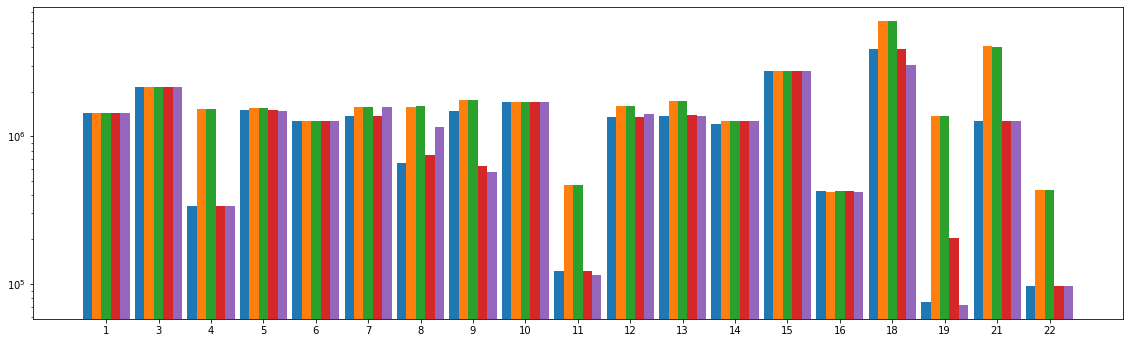

In [31]:
pdc = PostgresDatabaseConnector('indexselection_tpch___10')
what_if = WhatIfIndexCreation(pdc)

def exploit_indexes(recommended_indexes_per_query, indexes):
    for index in indexes:
        what_if.simulate_index(index, store_size=True)

    for query in workload.queries:
        plan = pdc.get_plan(query)
        plan_string = str(plan)
        cost = plan['Total Cost']
        recommended_indexes_per_query[query.nr] = (cost, [])
        for index in indexes:
            if index.hypopg_name in plan_string:
                recommended_indexes_per_query[query.nr][1].append(index)
    what_if.drop_all_simulated_indexes()

def costs_from_dict(d):
    costs = []
    for key in sorted(d.keys()):
        costs.append(d[key][0])
    return costs


for index in indexes_ms:
    what_if.simulate_index(index, store_size=True)

recommended_indexes_ms = {}
recommended_indexes_drop = {}
recommended_indexes_epic = {}
recommended_indexes_ibm = {}
exploit_indexes(recommended_indexes_ms, indexes_ms_history)
exploit_indexes(recommended_indexes_drop, indexes_drop_history)
exploit_indexes(recommended_indexes_epic, indexes_epic_history)
exploit_indexes(recommended_indexes_ibm, indexes_ibm_history)
costs_ms = costs_from_dict(recommended_indexes_ms)
costs_drop = costs_from_dict(recommended_indexes_drop)
costs_epic = costs_from_dict(recommended_indexes_epic)
costs_ibm = costs_from_dict(recommended_indexes_ibm)

no_index_costs = []
for query in workload.queries:
    if query.nr not in recommended_indexes_ms:
        continue
    no_index_costs.append(what_if_cost(Workload([query], 'ejal'), []))

labels = list(recommended_indexes_ms.keys())

pos = np.arange(len(labels))  # the label locations
width = 0.18  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar([p for p in pos], costs_ms, width, label='Microsoft')
rects2 = ax.bar([p + width*1 for p in pos], costs_drop, width, label='Drop')
rects3 = ax.bar([p + width*2 for p in pos], no_index_costs, width, label='No Index')
rects4 = ax.bar([p + width*3 for p in pos], costs_epic, width, label='EPIC')
rects5 = ax.bar([p + width*4 for p in pos], costs_ibm, width, label='IBM')

# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
# ax.set_xticks(x)
ax.set_xticks([p + 2 * width for p in pos])
ax.set_xticklabels(labels)
ax.set_yscale('log')
# ax.legend()


# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)

fig.tight_layout()
fig.set_size_inches(17, 5)
plt.show()

pdc.close()

# Step Table

In [ ]:
algorithm_names = sorted(['epic_max_indexes', 'microsoft-max2', 'ibm_max_indexes', 'drop_heuristic'])
# algorithm_names = sorted(['epic_max_indexes', 'ibm_max_indexes', 'drop_heuristic'])

algorithm_steps = {}

for algorithm_name in algorithm_names:
    path = f'{CSV_PATH}/results_{algorithm_name}_{BENCHMARK}_22_queries.csv'
    df = pd.read_csv(path,sep=';')
    df = df.drop(['q20'],axis=1)
    algorithm_steps[algorithm_name] = []
    for step, row in df.iterrows():
        cost = calculate_cost(df.columns, row)
        ast = AlgorithmStep(row['indexed columns'], row['#indexes'], step, row['memory consumption'], cost)
        algorithm_steps[algorithm_name].append(ast)

#     print(algorithm_name)
#     for step in algorithm_steps[algorithm_name]:
#         print(step)
#         print(f'Cost relative to no indexes: {step.workload_processing_cost / initial_cost * 100}%')
#         print()
#     print()
#     print()
#     print()

In [ ]:
df = pd.DataFrame(columns=['Step #', 'Metric'] + algorithm_names)
metrics = ['New Indexes', 'Removed Indexes', '% of previous / initial cost', 'Total Size (GB)']
most_steps = max(list(map(lambda x: len(algorithm_steps[x]), algorithm_steps)))
last_steps_indexes_per_algo = {}

previous_cost = {}
for algorithm_name in algorithm_names:
    previous_cost[algorithm_name] = initial_cost

for step in range(0, most_steps):
    for idx, metric in enumerate(metrics):
        df = df.append(pd.DataFrame([[step + 1 if idx == 0 else '', metric] + len(algorithm_names) * ['-']], columns=df.columns),ignore_index=True)
    for algorithm_name in algorithm_names:
        if algorithm_name not in last_steps_indexes_per_algo:
            last_steps_indexes_per_algo[algorithm_name] = set()
        if step < len(algorithm_steps[algorithm_name]):
            algorithm_step = algorithm_steps[algorithm_name][step]
            df[algorithm_name].values[-1] = algorithm_step.memory_consumption_gb()
            cost_relative_to_previous = algorithm_step.workload_processing_cost / previous_cost[algorithm_name] * 100
            previous_cost[algorithm_name] = algorithm_step.workload_processing_cost
            cost_relative_to_initial = algorithm_step.workload_processing_cost / initial_cost * 100
            cost_string = f'{algorithm_step.workload_processing_cost} ({cost_relative_to_previous:.2f}%)'
            cost_string = f'{cost_relative_to_previous:.2f}% / {cost_relative_to_initial:.2f}%'
            df[algorithm_name].values[-2] = cost_string
            
            indexes = set(cut_index_string(algorithm_step.indexes))
            removed_indexes = last_steps_indexes_per_algo[algorithm_name] - indexes
            new_indexes = indexes - last_steps_indexes_per_algo[algorithm_name]
            last_steps_indexes_per_algo[algorithm_name] = indexes
#             if 'drop' in algorithm_name:
#                 print(indexes)
#                 print(new_index)
#                 print()
#             assert len(new_index) == 1, f'There should be exactly one new index: {step} {algorithm_name}'
#             already_seen_indexes_per_algo[algorithm_name] |= (new_index)
            new_index_str = '\n'.join(new_indexes) if len(new_indexes) else '-'
#             new_index_str = next(iter(new_index))
#             new_index_str = new_index_str.replace(',', '\n')
            df[algorithm_name].values[-4] = new_index_str
            removed_index_str = '\n'.join(removed_indexes) if len(removed_indexes) else '-'
#             removed_index_str = removed_index_str.replace(',', '\n')
            df[algorithm_name].values[-3] = removed_index_str
            
            
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )
new_df = pretty_print(df.head(15 * len(metrics)))
new_df

In [ ]:
import html2markdown
html2markdown.convert(df.to_html(index=False).replace('\n', ''))

# Old Budget Table, multi steps, now single step

In [ ]:
algorithm_names = sorted(['epic', 'ibm', 'drop', 'microsoft'])
df_table = pd.DataFrame(columns=['Max Budget (GB)', 'Metric'] + algorithm_names)
metrics = ['New Indexes', 'Removed Indexes', '% of previous / initial cost']
last_steps_indexes_per_algo = {}
previous_cost = {}
for algorithm_name in algorithm_names:
    last_steps_indexes_per_algo[algorithm_name] = set()
    previous_cost[algorithm_name] = initial_cost
    
df_data_ibm = pd.read_csv(f'{CSV_PATH}/results_ibm_{BENCHMARK}_21_queries.csv',sep=';')
# df_data_ibm = df_data_ibm.drop(['q20'],axis=1)
df_data_epic = pd.read_csv(f'{CSV_PATH}/results_epic_{BENCHMARK}_21_queries.csv',sep=';')
# df_data_epic = df_data_epic.drop(['q20'],axis=1)
# df_data_drop = pd.read_csv(f'{CSV_PATH}/results_drop_heuristic_{BENCHMARK}_22_queries.csv',sep=';')
# df_data_drop = df_data_drop.drop(['q20'],axis=1)
# df_data_ms = pd.read_csv(f'{CSV_PATH}/results_microsoft-max2_{BENCHMARK}_22_queries.csv',sep=';')
# df_data_ms = df_data_ms.drop(['q20'],axis=1)

budgets_mb = [250, 500, 1000, 1500, 2500, 3500, 5000, 6500, 8000, 10000, 12000]

for (_, row_epic), (__, row_ibm), budget_mb in zip(df_data_epic.iterrows(), df_data_ibm.iterrows(), budgets_mb):
#     budget = json.loads(row_epic['parameters'])['budget']
#     budget_bytes = budget * 1000 * 1000
# budget in mb
    budget = budget_mb
    budget_bytes = budget * 1000 * 1000

    for idx, metric in enumerate(metrics):
        df_table = df_table.append(pd.DataFrame([[budget / 1000 if idx == 0 else '', metric] + len(algorithm_names) * ['-']], columns=df_table.columns),ignore_index=True)
    
    # EPIC
    current_indexes = set(cut_index_string(row_epic['indexed columns']))    
    new_index_str, removed_index_str = get_new_and_removed_indexes_str(current_indexes, last_steps_indexes_per_algo['epic'])
    df_table['epic'].values[-3] = new_index_str
    df_table['epic'].values[-2] = removed_index_str
    last_steps_indexes_per_algo['epic'] = current_indexes
    
    cost_string, cost = get_cost(df_data_epic.columns, row_epic, previous_cost['epic'], initial_cost)
    previous_cost['epic'] = cost
    df_table['epic'].values[-1] = cost_string
    
    # IBM
    current_indexes = set(cut_index_string(row_ibm['indexed columns']))    
    new_index_str, removed_index_str = get_new_and_removed_indexes_str(current_indexes, last_steps_indexes_per_algo['ibm'])
    df_table['ibm'].values[-3] = new_index_str
    df_table['ibm'].values[-2] = removed_index_str
    last_steps_indexes_per_algo['ibm'] = current_indexes
    
    cost_string, cost = get_cost(df_data_ibm.columns, row_ibm, previous_cost['ibm'], initial_cost)
    previous_cost['ibm'] = cost
    df_table['ibm'].values[-1] = cost_string
    
    #DROP
    relevant = df_data_drop[(df_data_drop['memory consumption'] < budget_bytes)].tail(1)
    if relevant.shape[0] > 0:
        row_drop = relevant.iloc[0]
        current_indexes = set(cut_index_string(row_drop['indexed columns']))
        new_index_str, removed_index_str = get_new_and_removed_indexes_str(current_indexes, last_steps_indexes_per_algo['drop'])
        df_table['drop'].values[-3] = new_index_str
        df_table['drop'].values[-2] = removed_index_str
        last_steps_indexes_per_algo['drop'] = current_indexes
    
        cost_string, cost = get_cost(df_data_ibm.columns, row_ibm, previous_cost['drop'], initial_cost)
        previous_cost['drop'] = cost
        df_table['drop'].values[-1] = cost_string
        
    #MS
    relevant = df_data_ms[(df_data_ms['memory consumption'] < budget_bytes)].tail(1)
    if relevant.shape[0] > 0:
        row_ms = relevant.iloc[0]
        current_indexes = set(cut_index_string(row_ms['indexed columns']))
        new_index_str, removed_index_str = get_new_and_removed_indexes_str(current_indexes, last_steps_indexes_per_algo['microsoft'])
        df_table['microsoft'].values[-3] = new_index_str
        df_table['microsoft'].values[-2] = removed_index_str
        last_steps_indexes_per_algo['microsoft'] = current_indexes
    
        cost_string, cost = get_cost(df_data_ibm.columns, row_ibm, previous_cost['microsoft'], initial_cost)
        previous_cost['microsoft'] = cost
        df_table['microsoft'].values[-1] = cost_string
    
    
        
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )
new_df = pretty_print(df_table)
new_df